# Tidy Text For Each Book
* read in pickles of each book in text format
* split into chapters
* run several functions to chunk the text

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textacy
import re
import pickle
import os

sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Load text files from pickles

### List all files in the chosen directory. It should only contain the text file pickles

In [152]:
raw_texts_dir = '../../../../Documents/murakami/pkl_raw_books/'
raw_texts_list = os.listdir(raw_texts_dir)

In [153]:
raw_texts_list

['HarukiMurakami_TheElephantVanishes.pkl',
 'HarukiMurakami_NorwegianWood.pkl',
 'HarukiMurakami_TheWindUpBirdChronicle.pkl',
 'HarukiMurakami_AWildSheepChase.pkl',
 'HarukiMurakami_KafkaOnTheShore.pkl',
 'HarukiMurakami_ColorlessTsukuruTazaki.pkl',
 'HarukiMurakami_NorwegianWoodB.pkl',
 'HarukiMurakami_DanceDanceDance.pkl']

### Extract the book names

In [154]:
# split the pkl file name on the . and _ and keep the book name
titles = [y.split('_')[1] for y in [x.split('.')[0] for x in raw_texts_list]]
# insert spaces between the capitalized words in the tiles
titles = [re.sub( r"([A-Z])", r" \1", z).strip() for z in titles]
titles

['The Elephant Vanishes',
 'Norwegian Wood',
 'The Wind Up Bird Chronicle',
 'A Wild Sheep Chase',
 'Kafka On The Shore',
 'Colorless Tsukuru Tazaki',
 'Norwegian Wood B',
 'Dance Dance Dance']

### Create dataframe containing the book titles and pkl file names

In [155]:
book_dict = {'Title':titles,'Pickle':raw_texts_list}

In [156]:
books = pd.DataFrame(book_dict)
books

,Title,Pickle
0,The Elephant Vanishes,HarukiMurakami_TheElephantVanishes.pkl
1,Norwegian Wood,HarukiMurakami_NorwegianWood.pkl
2,The Wind Up Bird Chronicle,HarukiMurakami_TheWindUpBirdChronicle.pkl
3,A Wild Sheep Chase,HarukiMurakami_AWildSheepChase.pkl
4,Kafka On The Shore,HarukiMurakami_KafkaOnTheShore.pkl
5,Colorless Tsukuru Tazaki,HarukiMurakami_ColorlessTsukuruTazaki.pkl
6,Norwegian Wood B,HarukiMurakami_NorwegianWoodB.pkl
7,Dance Dance Dance,HarukiMurakami_DanceDanceDance.pkl


### Load the text file for each book to the dataframe

In [157]:
def load_pickle(filename):
    in_path = raw_texts_dir + filename
    with open (in_path, 'rb') as fp:
        return pickle.load(fp)

In [158]:
books['full_text'] = books['Pickle'].apply(load_pickle)

In [159]:
books

,Title,Pickle,full_text
0,The Elephant Vanishes,HarukiMurakami_TheElephantVanishes.pkl,I’M IN THE kitchen cooking spaghetti when the ...
1,Norwegian Wood,HarukiMurakami_NorwegianWood.pkl,"[\n , Haruki Murakami Norwegian Wood This book..."
2,The Wind Up Bird Chronicle,HarukiMurakami_TheWindUpBirdChronicle.pkl,"[\n , \n , Contents \n Cover \n About the Auth..."
3,A Wild Sheep Chase,HarukiMurakami_AWildSheepChase.pkl,"[\n , \n \n \n , Contents \n Cover \n About th..."
4,Kafka On The Shore,HarukiMurakami_KafkaOnTheShore.pkl,[Kafka on the Shore \n Haruki Murakami \n \n \...
5,Colorless Tsukuru Tazaki,HarukiMurakami_ColorlessTsukuruTazaki.pkl,"[\n , \n \n \n , Contents \n Cover \n About th..."
6,Norwegian Wood B,HarukiMurakami_NorwegianWoodB.pkl,C H II P T E R 6 (rontinutd) The scene at dinn...
7,Dance Dance Dance,HarukiMurakami_DanceDanceDance.pkl,"[\n , \n \n \n , Contents \n Cover \n About th..."


### Initial cleaning and preparation of 'A Wild Sheep Chase' Text

In [160]:
wsc = books['full_text'].iloc[3]

In [161]:
# wsc is read from an epub and is a list of texts
len(wsc)

63

In [162]:
wsc[6][:30]

'\n PART ONE \n \n A PRELUDE \n '

In [163]:
wsc[6].startswith('\n PART')

True

In [164]:
# loop through the sections from 6 to 57 which contain the main body of the work
# the book is split into parts and we seperate the part headers from the main text
part_headers = []
texts = []
for i, section in enumerate(wsc[6:58]):
    if section.startswith('\n PART'):
        part_headers.append(section)
    else:
        texts.append(section)

In [165]:
# regex pattern to extract chapter number, title and main text from a complete chapter
pattern = re.compile(r'\n ([\d\w]+) \n \n ([^\n]+) \n ([\w\W]+)')

ch_nos = []
ch_titles = []
ch_texts = []
ireg_ch = []

for t in range(0,len(texts)):
#     print(t)
    out = re.findall(pattern, texts[t])
    if len(out) > 0:
        ch_nos.append(out[0][0])
        ch_titles.append(out[0][1])
        ch_texts.append(out[0][2])
    else:
        ireg_ch.append(texts[t])

In [166]:
# check if any irregular text
len(ireg_ch)

0

In [167]:
# create dataframe of chapters
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters.head()

,number,title,text
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...


### Generate 1000 character chunks of text

In [168]:
# function to find indices of full stops in a text
def fs_indexer(x):
    return [i for i, char in enumerate(x) if char == "."]

In [169]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))

In [170]:
chapters.head()

,number,title,text,fstop_indices
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65..."
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ..."
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ..."
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56..."


In [171]:
# function to find indices of full stops in a text
def split_indexer(text, n=1000):
    fstop_indices = fs_indexer(text)
    split_indices = []
    try:
        for j in range(n, len(text), n):
            i = 0
    # keep going through the indices while less than the 1000 step
            while fstop_indices[i] < j:
                i += 1
    # append list with the index of the full stop before the 1000 step
            split_indices.append(fstop_indices[i-1])
    except:
        split_indices = np.NaN
    return split_indices

In [172]:
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))

In [173]:
chapters.head()

,number,title,text,fstop_indices,split_indices
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961..."
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905..."
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]"
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995..."
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965]


In [174]:
# function to chunk a text
def text_chunker(text):
    split_indices = split_indexer(text)
    chunks = []
    for i, idx in enumerate(split_indices):
# if first split then start at index 0 and keep up to the full stop index (including the full stop)
        if i == 0:
            chunks.append(text[0:idx+1])
# else start from the end of the previous chunk after the full stop until the next
        else:
            chunks.append(text[split_indices[i-1]+2:idx+1])
    return chunks

In [175]:
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))

In [176]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th..."
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...


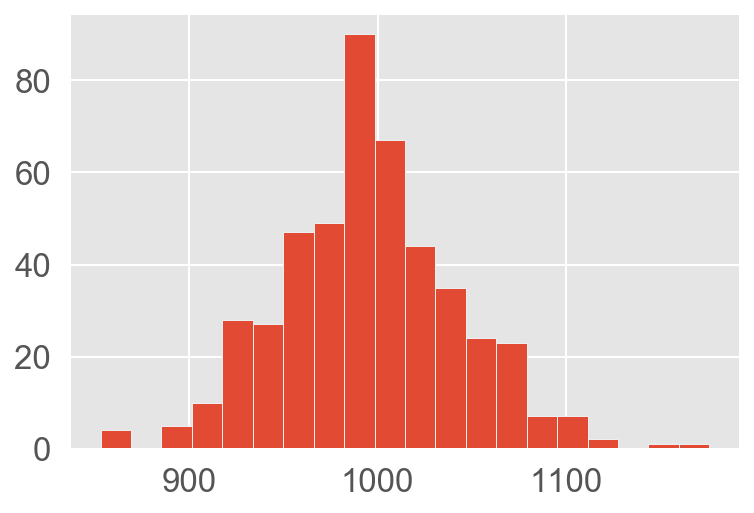

In [177]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [178]:
len(lengths)

471

In [179]:
chapters['translator'] = 'Alfred Birnbaum'

In [180]:
chapters['book_title'] = 'A Wild Sheep Chase'

In [181]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...,Alfred Birnbaum,A Wild Sheep Chase
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...,Alfred Birnbaum,A Wild Sheep Chase
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th...",Alfred Birnbaum,A Wild Sheep Chase
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...,Alfred Birnbaum,A Wild Sheep Chase
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...,Alfred Birnbaum,A Wild Sheep Chase


In [182]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'wsc_birnbaum_v01'
out_full_path = out_path + out_name + '.pkl'

In [183]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# read back pickle
with open (out_full_path, 'rb') as fp:
    read_wsc = pickle.load(fp)

In [184]:
read_wsc.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Wednesday Afternoon Picnic,IT WAS A short one-paragraph item in the morn...,"[57, 97, 115, 196, 318, 385, 420, 445, 504, 65...","[967, 1924, 2998, 3982, 4935, 5975, 6995, 7961...",[IT WAS A short one-paragraph item in the mor...,Alfred Birnbaum,A Wild Sheep Chase
1,2,Sixteen Steps,I WAITED FOR the compressed-air hiss of the e...,"[101, 215, 252, 271, 338, 413, 468, 625, 706, ...","[965, 1976, 2982, 3963, 4966, 5989, 6994, 7905...",[I WAITED FOR the compressed-air hiss of the ...,Alfred Birnbaum,A Wild Sheep Chase
2,3,The Slip,"ONCE SHE WAS gone, I downed another cola, the...","[76, 157, 246, 302, 371, 507, 543, 627, 699, 8...","[952, 1904, 2975, 3996, 4929]","[ONCE SHE WAS gone, I downed another cola, th...",Alfred Birnbaum,A Wild Sheep Chase
3,4,The Whale’s Penis and the Woman with Three Occ...,TO SLEEP WITH a woman: it can seem of the utm...,"[125, 229, 420, 514, 598, 686, 788, 874, 937, ...","[937, 1988, 2967, 3981, 4994, 5949, 6936, 7995...",[TO SLEEP WITH a woman: it can seem of the ut...,Alfred Birnbaum,A Wild Sheep Chase
4,5,Unblocked Ears,“ SEE WHAT I mean?” she said. \n She’d becom...,"[30, 84, 129, 178, 243, 314, 382, 481, 541, 56...",[965],[“ SEE WHAT I mean?” she said. \n She’d beco...,Alfred Birnbaum,A Wild Sheep Chase


### Initial cleaning and preparation of 'Dance Dance Dance' Text

In [185]:
ddd = books['full_text'].iloc[7]

In [186]:
len(ddd)

56

Selecting text from within list by manula check

In [187]:
ddd[7][:30]

'\n I OFTEN DREAM  about the Dol'

In [188]:
ddd[50][-30:]

'ispered.  “It’s morning.” \n \n '

In [189]:
ch_texts = ddd[7:51]

* No chapter titles available in the actual text so create them using counters
* Run similar splitting on full stops and add columnsa as before

In [190]:
ch_nos = range(1,45)
ch_titles = range(1,45)
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Alfred Birnbaum'
chapters['book_title'] = 'Dance Dance Dance'

In [191]:
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,\n I OFTEN DREAM about the Dolphin Hotel. \n ...,"[40, 119, 182, 233, 277, 322, 360, 396, 421, 4...","[881, 1974, 2990, 3882, 4988, 5962, 6982, 7990...",[\n I OFTEN DREAM about the Dolphin Hotel. \n...,Alfred Birnbaum,Dance Dance Dance
1,2,2,\n I GOT SENT to Hokkaido on assignment. As ...,"[39, 121, 208, 314, 519, 605, 660, 736, 781, 8...","[995, 1977, 2983, 3986, 4999, 5949, 6950]",[\n I GOT SENT to Hokkaido on assignment. As...,Alfred Birnbaum,Dance Dance Dance
2,3,3,\n IT TAKES NO great effort to find work in t...,"[95, 161, 287, 368, 407, 459, 497, 558, 596, 6...","[945, 1969, 2946, 3985, 4976, 5994, 6958, 7840]",[\n IT TAKES NO great effort to find work in ...,Alfred Birnbaum,Dance Dance Dance
3,4,4,"\n I BOOKED A taxi for two days, and the phot...","[127, 187, 282, 299, 428, 505, 597, 723, 784, ...","[979, 1960, 2993, 3999, 4943, 5959, 6979, 7964...","[\n I BOOKED A taxi for two days, and the pho...",Alfred Birnbaum,Dance Dance Dance
4,5,5,\n I COULDN’T STAND around gawking at the faç...,"[56, 145, 222, 321, 407, 502, 634, 649, 747, 8...","[877, 1975, 2889, 3971, 4904, 5992, 6983, 7952...",[\n I COULDN’T STAND around gawking at the fa...,Alfred Birnbaum,Dance Dance Dance


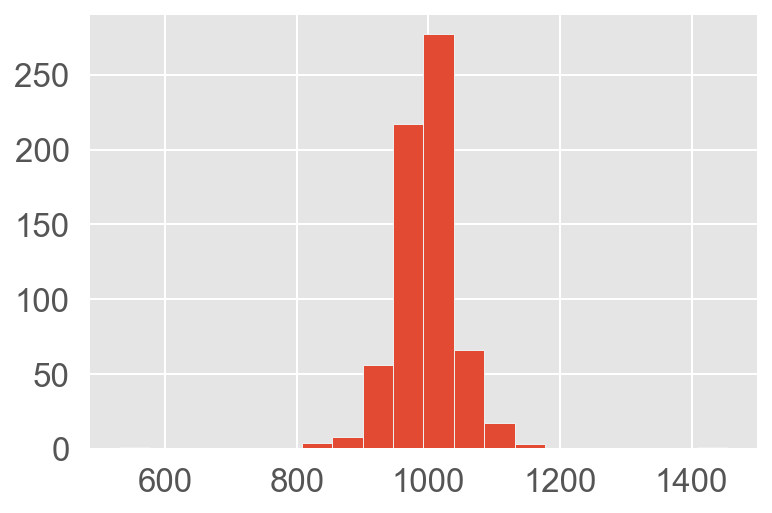

In [192]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [193]:
len(lengths)

650

In [194]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'ddd_birnbaum_v01'
out_full_path = out_path + out_name + '.pkl'

In [195]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_ddd = pickle.load(fp)

In [196]:
# read_ddd.head()

### Initial cleaning and preparation of 'Kafka On The Shore' Text

In [197]:
kots = books['full_text'].iloc[4]

In [198]:
len(kots)

53

In [199]:
texts = [ch for i, ch in enumerate(kots) if i not in [0,2]]

In [200]:
pattern1 = re.compile(r'\n ([\w\d\s]+) \n ([\w\W]+)')
pattern2 = re.compile(r'\n [\w]+ ([\d]+) \n [\w\W]+')

ch_nos = []
ch_titles = []
ch_texts = []

for t in range(0,len(texts)):
#     print(t)
    out1 = re.findall(pattern1, texts[t])
    out2 = re.findall(pattern2, texts[t])
#     print(len(out2))
    if len(out2) > 0:
        ch_nos.append(out2[0])
        ch_titles.append(out1[0][0])
        ch_texts.append(out1[0][1])
    else:
        ch_nos.append(None)
        ch_titles.append(out1[0][0])
        ch_texts.append(out1[0][1])

In [201]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters.dropna(inplace=True)
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters.dropna(inplace=True)
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Philip Gabriel'
chapters['book_title'] = 'Kafka On The Shore'
chapters.head(5)

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
1,1,Chapter 1,Cash isn't the only thing I take from my fathe...,"[73, 186, 247, 304, 368, 418, 490, 564, 675, 7...","[898, 1995, 2985, 3931, 4933, 5923, 6938, 7978...",[Cash isn't the only thing I take from my fath...,Philip Gabriel,Kafka On The Shore
2,2,Chapter 2,"The following document, classified Top Secret ...","[54, 56, 154, 222, 224, 252, 342, 375, 535, 57...","[878, 1901, 2996, 3947, 4936, 5847, 6928, 7936...","[The following document, classified Top Secret...",Philip Gabriel,Kafka On The Shore
3,3,Chapter 3,It's nearly dawn when I wake up. I draw the cu...,"[31, 72, 149, 230, 283, 312, 422, 553, 644, 68...","[982, 1949, 2758, 3877, 4974, 5952, 6982, 7986...",[It's nearly dawn when I wake up. I draw the c...,Philip Gabriel,Kafka On The Shore
4,4,Chapter 4,U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \n...,"[1, 3, 322, 422, 461, 576, 664, 754, 784, 786,...","[989, 1967, 2950, 3983, 4907, 5960, 6955, 7944...",[U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \...,Philip Gabriel,Kafka On The Shore
5,5,Chapter 5,I'm asleep when our bus drives across the huge...,"[77, 162, 217, 253, 329, 421, 465, 559, 582, 5...","[979, 1980, 2983, 3987, 4922, 5957, 6952, 7958...",[I'm asleep when our bus drives across the hug...,Philip Gabriel,Kafka On The Shore
6,6,Chapter 6,"Hello there,"" the old man called out. \n The l...","[36, 147, 193, 216, 243, 249, 250, 251, 271, 3...","[971, 1951, 2976, 3923, 4927, 5921, 6963, 7948...","[Hello there,"" the old man called out. \n The ...",Philip Gabriel,Kafka On The Shore
7,7,Chapter 7,At seven-fifteen I eat breakfast in the restau...,"[98, 165, 228, 298, 320, 378, 415, 511, 582, 6...","[948, 1907, 2982, 3928, 4921, 5973, 6997, 7999...",[At seven-fifteen I eat breakfast in the resta...,Philip Gabriel,Kafka On The Shore
8,8,\n Chapter 8,U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \n...,"[1, 3, 433, 537, 579, 618, 757, 869, 977, 1064...","[977, 1856, 2913, 3948, 4993, 5975, 6993, 7943...",[U.S. ARMY INTELLIGENCE SECTION (MIS) REPORT \...,Philip Gabriel,Kafka On The Shore
9,9,Chapter 9,"When I come to I'm in thick brush, lying there...","[79, 114, 247, 298, 357, 422, 493, 568, 615, 7...","[937, 1998, 2979, 3968, 4967, 5955, 6955, 7960...","[When I come to I'm in thick brush, lying ther...",Philip Gabriel,Kafka On The Shore
10,10,Chapter 10,"Is it all right, then, if Nakata calls you Kaw...","[178, 302, 356, 444, 486, 532, 597, 632, 666, ...","[954, 1913, 2986, 3937, 4946, 5993, 6978, 7964...","[Is it all right, then, if Nakata calls you Ka...",Philip Gabriel,Kafka On The Shore


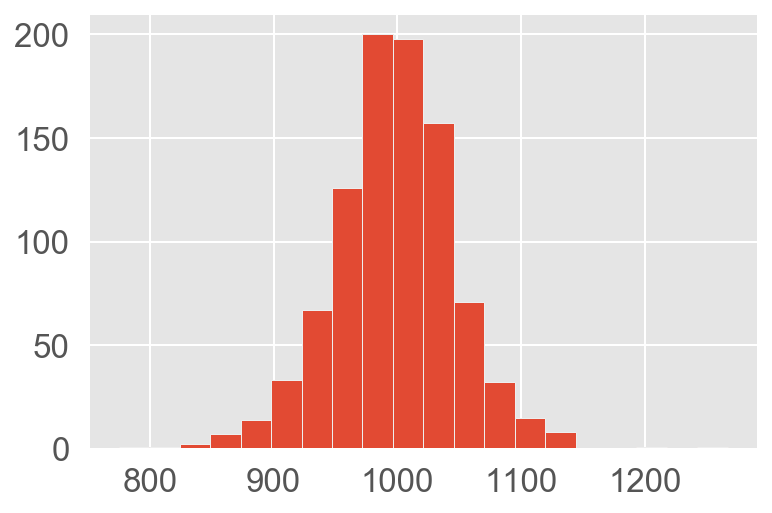

In [202]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [203]:
len(lengths)

934

In [204]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'kots_gabriel_v01'
out_full_path = out_path + out_name + '.pkl'

In [205]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_kots = pickle.load(fp)

In [206]:
# read_kots

### Initial cleaning and preparation of 'Colorless Tsukuru Tazaki' Text

In [207]:
ctt = books['full_text'].iloc[5]

In [208]:
len(ctt)

31

In [209]:
ctt[25][:200]

'19 \n SHINJUKU STATION IS  enormous.  Every day nearly 3.5 million people pass through it, so many that the  Guinness Book of World Records  officially lists JR Shinjuku Station as the station with the'

In [210]:
texts = ctt[7:26]

In [211]:
# regex pattern to extract chapter number, title and main text from a complete chapter
pattern = re.compile(r'([\d]+) \n ([\w\W]+)')

ch_nos = []
ch_titles = []
ch_texts = []
ireg_ch = []

for t in range(0,len(texts)):
#     print(t)
    out = re.findall(pattern, texts[t])
    if len(out) > 0:
        ch_nos.append(out[0][0])
        ch_titles.append(out[0][0])
        ch_texts.append(out[0][1])
    else:
        ch_nos.append(None)
        ch_titles.append(None)
        ch_texts.append(None)

In [212]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Philip Gabriel'
chapters['book_title'] = 'Colorless Tsukuru Tazaki'
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,FROM JULY OF his sophomore year in college un...,"[119, 219, 340, 450, 591, 625, 806, 871, 933, ...","[996, 1983, 2948, 3943, 4964, 5996, 6975, 7944...",[FROM JULY OF his sophomore year in college u...,Philip Gabriel,Colorless Tsukuru Tazaki
1,2,2,THIS DRASTIC CHANGE took place during summer ...,"[116, 253, 405, 531, 572, 628, 804, 889, 911, ...","[999, 1845, 2998, 3925, 4956, 5982, 6995, 7914...",[THIS DRASTIC CHANGE took place during summer...,Philip Gabriel,Colorless Tsukuru Tazaki
2,3,3,IN THE HALF year when he wandered on the verg...,"[85, 132, 222, 290, 352, 416, 481, 574, 606, 7...","[956, 1909, 2907, 3960, 4999, 5910, 6979, 7934...",[IN THE HALF year when he wandered on the ver...,Philip Gabriel,Colorless Tsukuru Tazaki
3,4,4,HE MET THE man at the college pool. \n Like T...,"[35, 96, 178, 276, 355, 512, 600, 639, 675, 70...","[988, 1998, 2952, 3984, 4989, 5960, 6956, 7886...",[HE MET THE man at the college pool. \n Like ...,Philip Gabriel,Colorless Tsukuru Tazaki
4,5,5,"‘ WHEN MY FATHER was young, he spent a year w...","[81, 206, 362, 435, 581, 677, 818, 902, 944, 1...","[944, 1991, 2976, 3844, 4986, 5979, 6962, 7969...","[‘ WHEN MY FATHER was young, he spent a year ...",Philip Gabriel,Colorless Tsukuru Tazaki


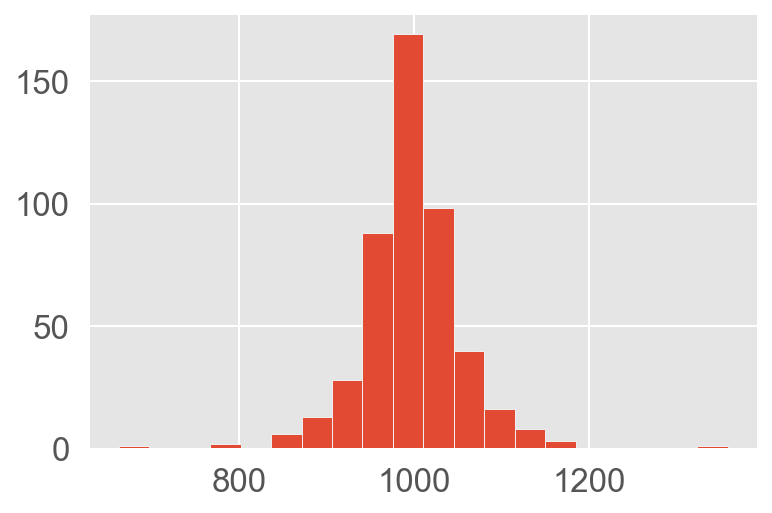

In [213]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [214]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'ctt_gabriel_v01'
out_full_path = out_path + out_name + '.pkl'

In [215]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_ctt = pickle.load(fp)

In [216]:
# read_ctt

### Initial cleaning and preparation of 'The Wind Up Bird Chronicle' Text

In [217]:
wubc = books['full_text'].iloc[2]

In [218]:
len(wubc)

83

In [219]:
texts = wubc[7:77]

In [220]:
# regex pattern to extract chapter number, title and main text from a complete chapter
# first pattern for most chapters
pattern1 = re.compile(r'(\d+) \n ([\d\w\W\n]+ \n ♦ \n [^\n]+) \n ([\w\W]+)')
#  second pattern for some irregular chapters - useful finding first few all capitals
pattern2 = re.compile(r'(\d+) \n ([\d\w\W]+) \n ([A-Z]{1,}\s[A-Z]{2,}[\d\w\W]+)')

ch_nos = []
ch_titles = []
ch_texts = []

for t in range(0,len(texts)):
#     print(t)
    out = re.findall(pattern1, texts[t])
    if len(out) > 0:
        ch_nos.append(out[0][0])
        ch_titles.append(out[0][1])
        ch_texts.append(out[0][2])
    else:
        try:
            out = re.findall(pattern2, texts[t])
            ch_nos.append(out[0][0])
            ch_titles.append(out[0][1])
            ch_texts.append(out[0][2])
        except:
            ch_nos.append(None)
            ch_titles.append(None)
            ch_texts.append(out)

In [221]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_titles, 'text': ch_texts})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters.dropna(inplace=True)
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters.dropna(inplace=True)
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Jay Rubin'
chapters['book_title'] = 'The Wind Up Bird Chronicle'
chapters.head(5)

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Tuesday’s Wind-up Bird \n ♦ \n Six Fingers and...,"WHEN THE PHONE rang I was in the kitchen, boi...","[215, 377, 413, 461, 538, 594, 666, 737, 759, ...","[968, 1946, 2996, 3973, 4966, 5879, 6990, 7902...","[WHEN THE PHONE rang I was in the kitchen, bo...",Jay Rubin,The Wind Up Bird Chronicle
1,2,Full Moon and Eclipse of the Sun \n ♦ \n On Ho...,"IS IT POSSIBLE , in the final analysis, for on...","[458, 558, 625, 676, 778, 940, 1041, 1091, 118...","[940, 1999, 2990, 3955, 4955, 5911, 6963, 7884...","[IS IT POSSIBLE , in the final analysis, for o...",Jay Rubin,The Wind Up Bird Chronicle
2,3,Malta Kano’s Hat \n ♦ \n Sherbet Tone and Alle...,I WAS IN the middle of preparing lunch when t...,"[65, 287, 352, 499, 534, 556, 584, 654, 717, 8...","[983, 1978, 2999, 3993, 4996, 5911, 6967, 7981...",[I WAS IN the middle of preparing lunch when ...,Jay Rubin,The Wind Up Bird Chronicle
3,4,"High Towers and Deep Wells \n (Or, Far from No...","I listened, making suitable responses. I hear...","[37, 88, 151, 275, 309, 420, 517, 602, 641, 69...","[897, 1861, 2946, 3953, 4988, 5931, 6994, 7985...","[I listened, making suitable responses. I hea...",Jay Rubin,The Wind Up Bird Chronicle
4,5,Hooked on Lemon Drops \n ♦ \n Flightless Bird ...,"AFTER DOING THE breakfast dishes, I rode my b...","[81, 268, 373, 467, 618, 754, 790, 911, 983, 1...","[983, 1918, 2875, 3850, 4944, 5979, 6916, 7950...","[AFTER DOING THE breakfast dishes, I rode my ...",Jay Rubin,The Wind Up Bird Chronicle


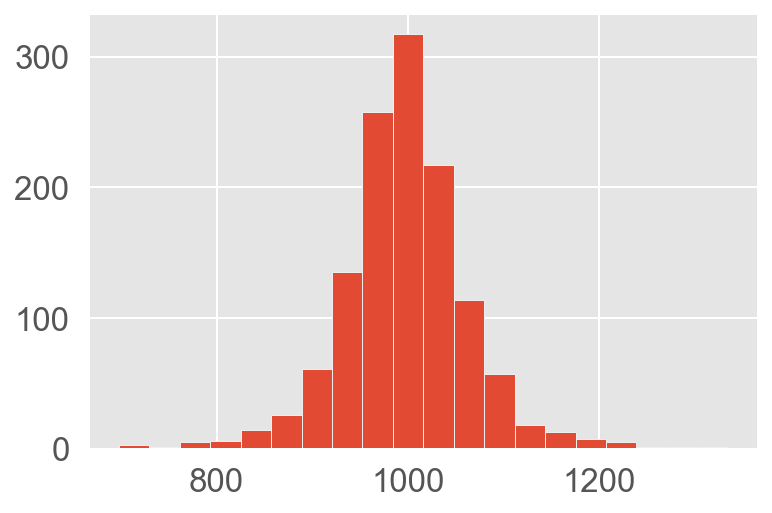

In [222]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [223]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'wubc_rubin_v01'
out_full_path = out_path + out_name + '.pkl'

In [224]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_wubc = pickle.load(fp)

In [225]:
# read_wubc

### Initial cleaning and preparation of 'Norwegian Wood' Text

In [226]:
nw = books['full_text'].iloc[1]

In [227]:
nw = nw[1:3]

In [228]:
nw_main1 = nw[0].split('subsequent purchaser ')[1]
nw_main2 = nw[1]
nw_main2 = nw_main2.split(' TRANSLATOR’S NOTE ')[0]

In [229]:
chapters = pd.DataFrame({'number': [1,2], 'title': ['Book 1', 'Book 2'], 'text': [nw_main1, nw_main2]})
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters.dropna(inplace=True)
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters.dropna(inplace=True)
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Jay Rubin'
chapters['book_title'] = 'Norwegian Wood'
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,Book 1,"I was 37 then, strapped in my seat as the huge...","[115, 300, 320, 473, 569, 643, 734, 761, 794, ...","[868, 1999, 2992, 3970, 4862, 5962, 6988, 7972...","[I was 37 then, strapped in my seat as the hug...",Jay Rubin,Norwegian Wood
1,2,Book 2,"m\n \nsf Thanks for your letter,\n wrote Naoko...","[43, 88, 213, 296, 343, 376, 480, 632, 695, 74...","[924, 1926, 2925, 3997, 4861, 5754, 6924, 7914...","[m\n \nsf Thanks for your letter,\n wrote Naok...",Jay Rubin,Norwegian Wood


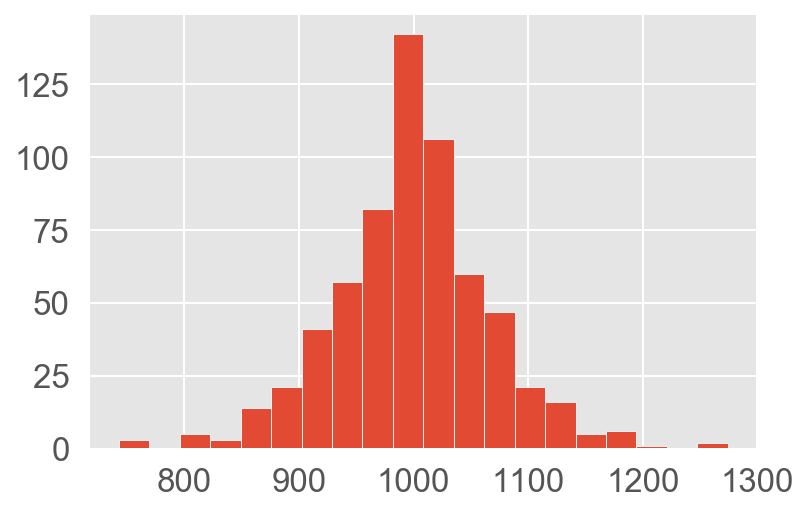

In [230]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [231]:
len(lengths)

632

In [232]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'nw_rubin_v01'
out_full_path = out_path + out_name + '.pkl'

In [233]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_nw = pickle.load(fp)

### Initial cleaning and preparation of 'Norwegian Wood' - Birnbaum Translation Text

In [235]:
nw_b = books['full_text'].iloc[6]

In [236]:
# nwb is read from a pdf and is a long string
len(nw_b)

298558

In [237]:
chaps = nw_b.split('CHAPTER ')

In [238]:
len(chaps)

6

In [239]:
texts = chaps

In [240]:
pattern = re.compile(r'(\d+) ([\w\W]+)')

ch_nos = []
# ch_titles = []
ch_texts = []

for t in range(0,len(texts)):
    out = re.findall(pattern, texts[t])
    if len(out) > 0:
        ch_nos.append(out[0][0])
#         ch_titles.append(out[0][1])
        ch_texts.append(out[0][1])
    else:
        ch_nos.append(None)
#         ch_titles.append(None)
        ch_texts.append(None)

In [241]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_nos, 'text': ch_texts})
chapters.head(5)

,number,title,text
0,6,6,(rontinutd) The scene at dinner was pretty muc...
1,7,7,The next day I had my Thursday morning gym cla...
2,8,8,In the middle of the week I cut my hand badly ...
3,9,9,Midori didn't show for up the following Monday...
4,10,10,1969 was one hopeless swamp of a year. I felt ...
5,11,11,"Even after Naoko died, Reiko continued to writ..."


In [242]:
chapters.iloc[0,2] = chapters.iloc[0,2].split('(rontinutd) ')[1]

In [243]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))
chapters.dropna(inplace=True)

In [244]:
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters.dropna(inplace=True)
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = 'Alfred Birnbaum'
chapters['book_title'] = 'Norwegian Wood'

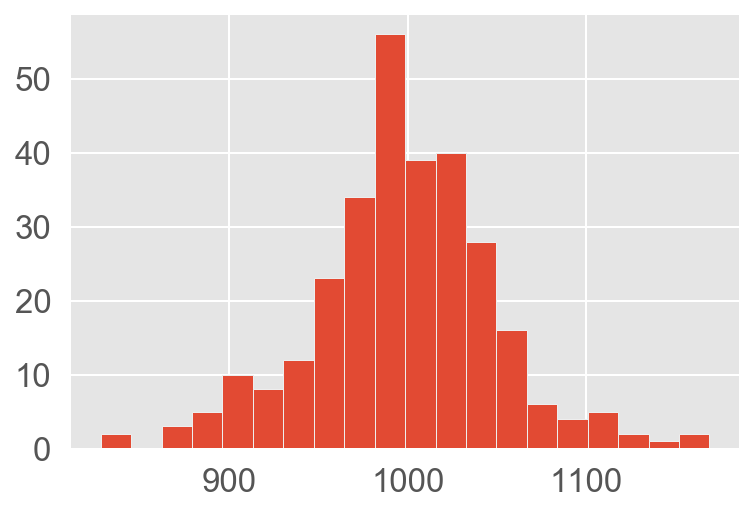

In [245]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [246]:
len(lengths)

296

In [247]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'nw_birnbaum_v01'
out_full_path = out_path + out_name + '.pkl'

In [248]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_nw = pickle.load(fp)

### Initial cleaning and preparation of 'The Elephant Vanishes' Text

In [250]:
ev = books['full_text'].iloc[0]

In [251]:
# split the full text on triple line break to split into stories
# we have 14 stories
len(ev.split('\n\n\n'))

14

In [252]:
# split the book into stories on the phrase 'translated by' 
# then take whatever is after that up to a line break
trans_list = []
for story in ev.split('\n\n\n'):
    trans_list.append(story.split('translated by')[1].split('\n')[0])

In [253]:
trans_list

[' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Jay Rubin',
 ' Alfred Birnbaum',
 ' Alfred Birnbaum',
 ' Jay Rubin']

In [254]:
ch_texts = ev.split('\n\n\n')

In [255]:
ch_nos = [i+1 for i in range(len(ch_texts))]

In [256]:
chapters = pd.DataFrame({'number': ch_nos, 'title': ch_nos, 'text': ch_texts})
chapters.head()

,number,title,text
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...
1,2,2,I’M STILL NOT sure I made the right choice whe...
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a..."
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ..."
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...
5,6,6,"\n“MOTHER DUMPED MY Father,” a friend of my wi..."
6,7,7,I MET HER at the wedding party of an acquainta...
7,8,8,"GREETINGS,\nThe winter cold diminishes with ea..."
8,9,9,IT WAS SUNDAY evening when the TV People showe...
9,10,10,WHEN DID I meet my first Chinese?\nJust like t...


In [257]:
chapters['fstop_indices'] = chapters['text'].apply(lambda x: fs_indexer(x))

In [258]:
chapters.dropna(inplace=True)
chapters['split_indices'] = chapters['text'].apply(lambda x: split_indexer(x))
chapters.dropna(inplace=True)
chapters['chunks'] = chapters['text'].apply(lambda x: text_chunker(x))
chapters['translator'] = trans_list
chapters['book_title'] = 'The Elephant Vanishes'
chapters.head()

,number,title,text,fstop_indices,split_indices,chunks,translator,book_title
0,1,1,I’M IN THE kitchen cooking spaghetti when the ...,"[57, 188, 221, 275, 309, 416, 571, 643, 717, 7...","[932, 1991, 2929, 3948, 4981, 5988, 6998, 7953...",[I’M IN THE kitchen cooking spaghetti when the...,Alfred Birnbaum,The Elephant Vanishes
1,2,2,I’M STILL NOT sure I made the right choice whe...,"[86, 150, 228, 311, 326, 334, 426, 568, 632, 6...","[962, 1872, 2949, 3966, 4960, 5996, 6970, 7941...",[I’M STILL NOT sure I made the right choice wh...,Jay Rubin,The Elephant Vanishes
2,3,3,"SAY HEY, HOW’S tricks?\nThis morning, I paid a...","[84, 141, 180, 259, 306, 334, 354, 389, 431, 4...","[995, 1881, 2973, 3845, 4993, 5979, 6936, 7990...","[SAY HEY, HOW’S tricks?\nThis morning, I paid ...",Alfred Birnbaum,The Elephant Vanishes
3,4,4,"ONE BEAUTIFUL APRIL morning, on a narrow side ...","[132, 181, 215, 248, 308, 400, 477, 567, 766, ...","[932, 1944, 2993, 3893, 4937, 5947, 6878, 7849...","[ONE BEAUTIFUL APRIL morning, on a narrow side...",Jay Rubin,The Elephant Vanishes
4,5,5,1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST NO...,"[1, 101, 156, 368, 473, 594, 689, 813, 890, 10...","[890, 1983, 2947, 3929, 4953, 5843, 6987, 7888...",[1.\nTHE FALL\nOF THE\nROMAN EMPIRE\nI FIRST N...,Alfred Birnbaum,The Elephant Vanishes


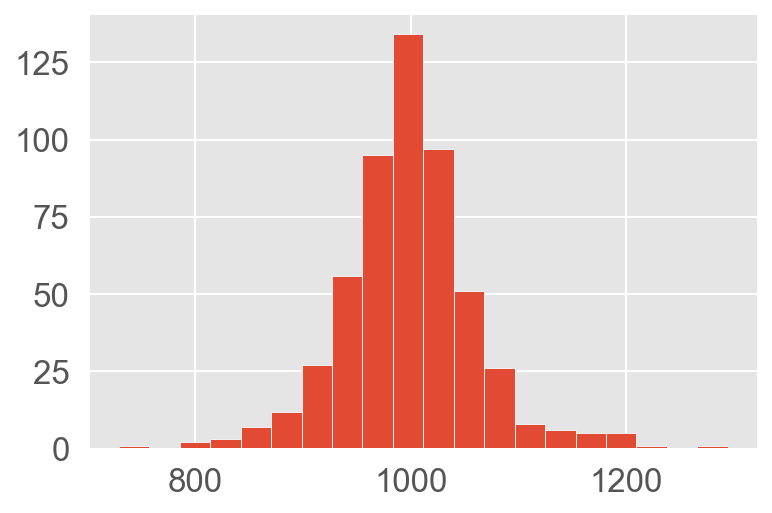

In [259]:
lengths = []
for chapter in chapters['chunks']:
    for chunk in chapter:
        lengths.append(len(chunk))
plt.hist(lengths, bins=20);

In [260]:
len(lengths)

537

In [261]:
out_path = '../../../../Documents/murakami/pkl2/'
out_name = 'ev_birnbaum_rubin_v01'
out_full_path = out_path + out_name + '.pkl'

In [262]:
# save pickle
with open(out_full_path, 'wb') as fp:
    pickle.dump(chapters, fp)


# # read back pickle
# with open (out_full_path, 'rb') as fp:
#     read_ev = pickle.load(fp)